In [6]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Generate Data
***

# $y_{true}=mx+b$
# $y=y_{true} + N(0,\sigma)$
***

In [7]:
true_slope = 5
true_intercept = 10
true_sigma = 1

num_points = 10

x_vals = np.linspace(0, 1, num_points)
true_y_vals = true_slope * x_vals + true_intercept
y_vals = true_y_vals + np.random.normal(scale=true_sigma, size=num_points)

true_params = {'slope': true_slope, 'intercept': true_intercept, 'sigma': true_sigma}

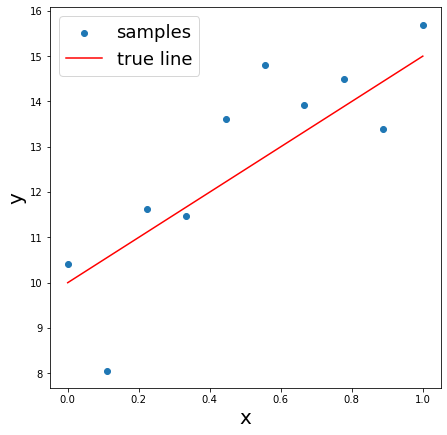

In [8]:
plt.figure(figsize=(7,7))
p1 = plt.scatter(x_vals, y_vals)
p2, = plt.plot(x_vals, true_y_vals, color='r')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.legend((p1, p2), ('samples', 'true line'), fontsize=18)

# Fit a Usual Linear Model

In [9]:
clf = LinearRegression()
clf.fit(x_vals.reshape(-1,1), y_vals)
preds = clf.predict(x_vals.reshape(-1,1))
resids = preds - y_vals

print('True Model:')
print('y_true = %s*x + %s'%(true_slope, true_intercept))
print('True sigma: %s\n'%true_params['sigma'])

print('Estimated Model:')
print('y_hat = %s*x + %s'%(clf.coef_[0], clf.intercept_))
print('Sd Residuals: %s'%(resids.std()))

mle_estimates = {'slope': clf.coef_[0], 'intercept': clf.intercept_, 'sigma': resids.std()}

True Model:
y_true = 5*x + 10
True sigma: 1

Estimated Model:
y_hat = 5.878905821235632*x + 9.809165100408059
Sd Residuals: 1.1671699468687426


# Bayesian Analysis with PyMC3
***

# Priors:
## $m \sim N(0,20)$
## $b \sim N(0,20)$
## $\sigma \sim Exp(1)$
***

# Likelihood:
## $y|m,b,\sigma \sim N(mx+b, \sigma)$
***

# Posterior
## $m,b,\sigma | y \sim ?$
## $P(m,b,\sigma|y) \propto P(y|m,b,\sigma) \times P(m) \times P(b) \times P(\sigma)$
***

In [10]:
with pm.Model() as model:
    #priors
    sigma = pm.Exponential("sigma", lam=1.0)
    intercept = pm.Normal("intercept", mu=0, sigma=20)
    slope = pm.Normal("slope", mu=0, sigma=20)

    #Likelihood
    likelihood = pm.Normal("y", mu=slope*x_vals + intercept, sigma=sigma, observed=y_vals)

    #posterior
    trace = pm.sample(1000, cores=4)

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\ritvik\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\ritvik\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6918304722688693, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
C:\Users\ritvik\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 504x504 with 0 Axes>

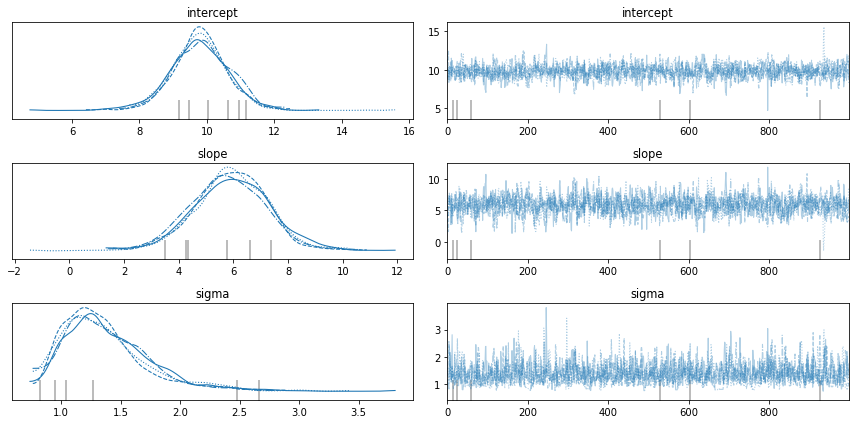

In [11]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()

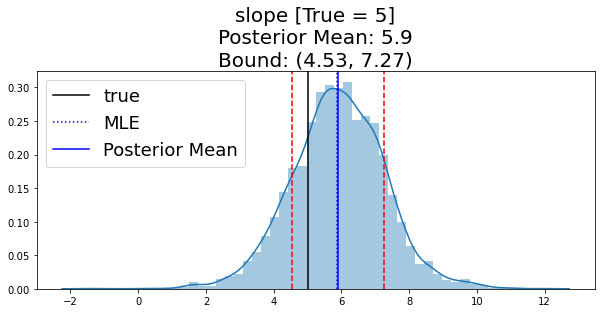

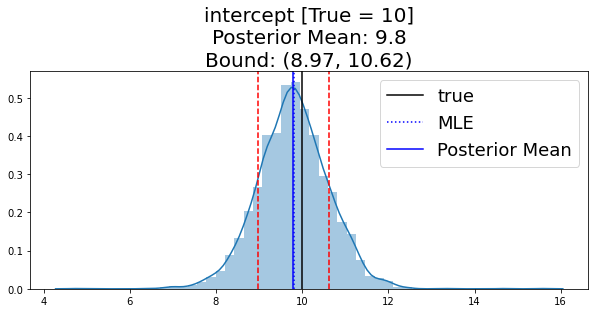

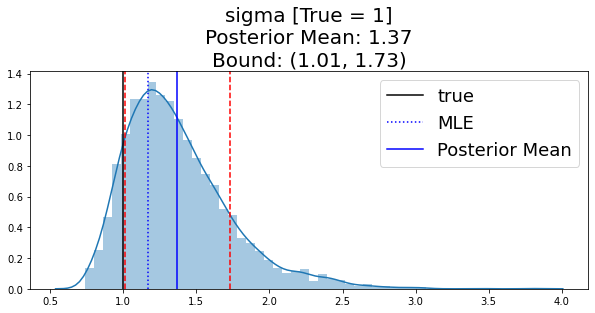

In [12]:
for var in ['slope', 'intercept', 'sigma']:
    plt.figure(figsize=(10,4))
    vals = trace.get_values(var)
    mean, lower, upper = round(vals.mean(),2), round(vals.mean()-vals.std(),2), round(vals.mean()+vals.std(),2)
    sns.distplot(vals)
    posterior_est = plt.axvline(mean, color='b')
    mle_est = plt.axvline(mle_estimates[var], color='b', linestyle='dotted')
    plt.axvline(lower, color='r', linestyle='--')
    plt.axvline(upper, color='r', linestyle='--')
    plt.title('%s [True = %s]\nPosterior Mean: %s\nBound: (%s, %s)'%(var,true_params[var],mean,lower,upper), fontsize=20)
    true_val = plt.axvline(true_params[var], color='k')
    
    plt.legend((true_val, mle_est, posterior_est), ('true', 'MLE', 'Posterior Mean'), fontsize=18)
    
    plt.show()